In [1]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import matplotlib.colors as mcolors
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
%matplotlib inline

In [2]:
# Import data frames
train_df = pd.read_pickle('data-2/train_df.pkl')
val_df = pd.read_pickle('data-2/val_df.pkl')

In [3]:
# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    #fig = None
    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show kps
    
    for i in range(1, len(keypoints), 2):
        x = keypoints[i-1]
        y = keypoints[i]
        x = (x)*w + w/2
        y = (y)*h + h/2
        if x < 0 or y < 0: continue
        colors = ['red', 'blue', 'magenta', 'lime', 'orange', 'purple', 'pink', 'yellow', 'aqua', 'fuchsia', 'azure', 'lavender', 'magenta', 'white', 'sienna', 'indigo', 'coral']
        ax.plot(x, y, marker='x', color=colors[i//2])
    if(show):
        plt.show()

In [4]:
# normalizing transform defined in the DeepPose paper
# y is a 2 vec, b is a 4 vec of bcx, bcy, bw, bh
def N(y, b):
    return [ (y[0]-b[0]) * 1/b[2], (y[1]-b[1]) * 1/b[3]]

def Ninv(y, b):
    return []

In [5]:
# Create datasets for training and validation
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'data-2/{self.source}2017/{self.df.iloc[index]["path"]}')
        
        # Apply transforms to image
        if self.transform: img = self.transform(img)

        label = torch.FloatTensor(self.df.iloc[index]["keypoints"])

        # random augmentation
        
        
        # Return data
        return img, label

    def __len__(self):
        return len(self.df)

tensor([[ 0.2750, -0.3067,  0.3333, -0.3178,  0.2500, -0.3253,  0.3750, -0.2881,
          0.1833, -0.3104,  0.3583, -0.1431,  0.0083, -0.2584,  0.4083,  0.0019,
         -0.2417, -0.3327,  0.3583, -0.0167, -0.3833, -0.4257,  0.1167,  0.0539,
         -0.1250,  0.0093,  0.1833,  0.2398, -0.3167,  0.2509,  0.2250,  0.4368,
         -0.2250,  0.3699]])


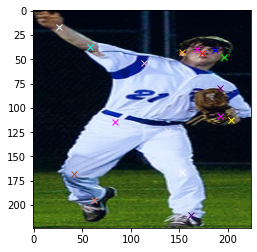

In [6]:
# Data loader
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataloader = DataLoader(
    dataset=Coco(train_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=True, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
print(labels)
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [28]:
# Initialize network
'''
model = models.resnet18(pretrained=True)#models.mobilenet_v2(pretrained=True)

# Freeze params
'''
#for param in model.parameters():
#    param.requires_grad = False
'''

# Replace FC
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False), 
    torch.nn.Linear(512, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 4096),
    nn.ReLU(),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(4096, 34),
    torch.nn.Sigmoid()
    ) 
model = model.to(device)
model
'''

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 96, kernel_size=(11, 11), stride=(4,4), padding=(5,5)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(96),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2,2)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),

    torch.nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(384),

    torch.nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(256),

    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Flatten(),

    torch.nn.Linear(12544, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.6),

    torch.nn.Linear(4096, 34),
)

model = model.to(device)
model(torch.rand(32,3,224, 224).to('cuda')).shape


torch.Size([32, 34])

In [15]:
model.load_state_dict(torch.load("model.save", map_location=device))

<All keys matched successfully>

In [29]:
val_dataset = Coco(val_df, 'val', 224, transform=composed_transforms)
batch_size = 32
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

def check_validation_accuracy(model):
    
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs) - 0.5
            loss += criterion(outputs, labels)

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    '''
    idx = rn.randint(0, 150)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu') - 0.5

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)
    '''
    return loss 
    

check_validation_accuracy(model)

Validiation loss was 1.8128951787948608


tensor(1.8129, device='cuda:0')

Training 3600 epochs. Dataset is 4037 big. Using batch size 64
64 minibatches are needed per epoch
Minibatch 1/64. Loss 0.021005261689424515
Minibatch 51/64. Loss 0.021436596289277077
Epoch 0/2. Loss 1.4013552851974964
Validiation loss was 0.11414852738380432
Minibatch 1/64. Loss 0.022568758577108383
Minibatch 51/64. Loss 0.020712217316031456
Epoch 1/2. Loss 1.3972407579421997
Validiation loss was 0.1139996126294136
Minibatch 1/64. Loss 0.0221931803971529
Minibatch 51/64. Loss 0.025234254077076912
Epoch 2/2. Loss 1.3985385056585073
Validiation loss was 0.11345021426677704
Minibatch 1/64. Loss 0.022063659504055977
Minibatch 51/64. Loss 0.025774460285902023
Epoch 3/2. Loss 1.3865121994167566
Validiation loss was 0.11358317732810974
Minibatch 1/64. Loss 0.020792238414287567
Minibatch 51/64. Loss 0.021311290562152863
Epoch 4/2. Loss 1.384847965091467
Validiation loss was 0.11036022007465363
Minibatch 1/64. Loss 0.017871243879199028
Minibatch 51/64. Loss 0.023546861484646797
Epoch 5/2. Loss

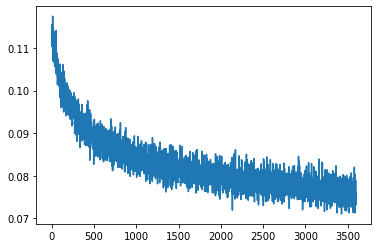

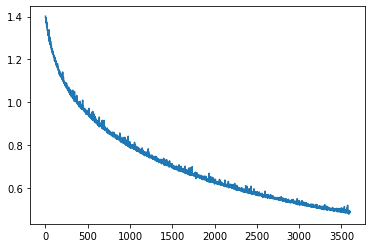

In [53]:
# TRAINING
train_dataset = Coco(train_df, 'train', 224, transform=composed_transforms)
batch_size = 64
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)

# Define loss and optimizer
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.001)#optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

epochs = 300

print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
print(f"{len(train_dataset)//batch_size+1} minibatches are needed per epoch")

train_loss_history = []
val_loss_history = []

# Train for 2 epochs
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs) - 0.5
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
            print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

    # print statistics
    print(f"Epoch {epoch}/2. Loss {running_loss}")
    train_loss_history.append(running_loss)
    val_loss_history.append(check_validation_accuracy(model))
    if(epoch % 100 == 0):
        torch.save(model.state_dict(), f'models/model_{epoch}.save')

# save model
plt.plot(val_loss_history)
plt.figure()
plt.plot(train_loss_history)
torch.save(model.state_dict(), 'model.save')

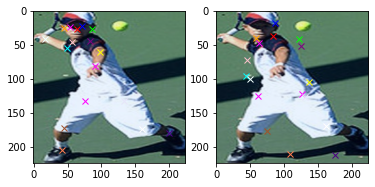

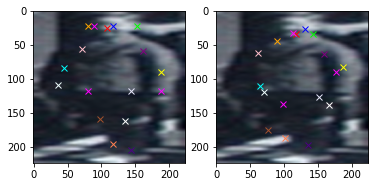

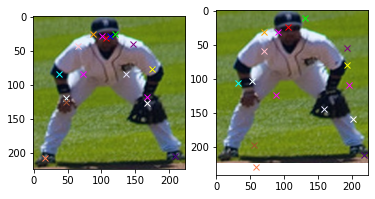

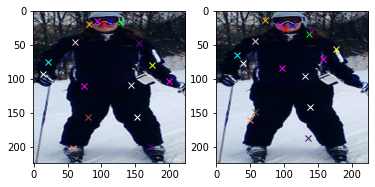

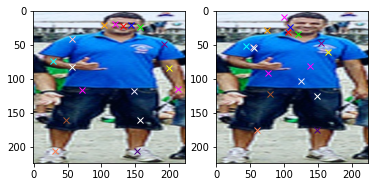

tensor([-0.0288, -0.3640, -0.0137, -0.3930, -0.0562, -0.4620,  0.0361, -0.3519,
        -0.1647, -0.3720,  0.1898, -0.2885, -0.2585, -0.2644,  0.2322, -0.2292,
        -0.3044, -0.2712,  0.1148, -0.1390, -0.2518, -0.2576,  0.0568, -0.0411,
        -0.1568, -0.0919,  0.1657,  0.0558, -0.1466,  0.0439,  0.1595,  0.2817,
        -0.2349,  0.2813], grad_fn=<SelectBackward0>)


In [78]:
for q in range(0, 5):
    idx = rn.randint(0, 150)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)

    img = img.to(device)
    outputs = model(img.unsqueeze(0)) - 0.5
    outputs = outputs.to('cpu')

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

print(outputs[0])